In [215]:
import pandas as pd 
import numpy as np 
import os
import glob
import subprocess
from tqdm import tqdm
import itertools
import networkx as nx
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import math
import re
from utils import * 
from src.data import * 
import json
import sklearn
import io 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
def load_align(path:str):
    cols = ['query', 'target', 'evalue', 'pident', 'bits', 'qseq', 'tseq', 'alnlen', 'qstart', 'qend', 'tstart', 'tend', 'mismatch','gapopen']
    # cols = ['query', 'target', 'evalue', 'pident', 'bits', 'qseq', 'tseq', 'alnlen', 'qstart', 'qend', 'tstart', 'tend', 'qaln', 'taln']
    align_df = pd.read_csv(path, sep='\t', header=None, names=cols)
    align_df = align_df[align_df.bits > 50].copy()
    align_df['start_offset'] = np.abs(align_df.qstart - align_df.tstart)
    align_df['alignment_id'] = [' - '.join(sorted([row.target, row.query])) for row in align_df.itertuples()]
    align_df = align_df[align_df['query'] != align_df['target']].copy() # Drop self-alignments.
    align_df = align_df.sort_values('bits').drop_duplicates('alignment_id') # Drop duplicate alignments.
    return align_df

In [217]:
# NOTE: I modified some of the plasmid file names for consistency with the metadata, e.g. pTiS4 to S4_ti
# TODO: What is the Atu or Avi prefix? Should I not have changed those?

metadata_df = load_weisberg_2020_metadata()

In [218]:
for path in glob.glob('../data/data-1/ncbi/genbank/*'):
    fasta_path = os.path.basename(path).replace('.gbk', '.fn')
    fasta_path = os.path.join('../data/data-1/ncbi/fasta/', fasta_path)
    if not os.path.exists(fasta_path):
        print(f'Writing FASTA nucleotide file to {fasta_path}')
        file = GBKFile(path)
        file.to_fasta(fmt='nt', path=fasta_path)

# Created HMM library by concatenating individual HMM filed into library.hmm.
# Had to manually-remove a string containing "ELEMENTS OF EXTERNAL ORIGIN;" because it caused issues with parsing. 
for path in tqdm(glob.glob('../data/data-1/ncbi/fasta/*'), 'Running HMMs on plasmids...'):
    source_id = os.path.basename(path).replace('.fn', '')
    output_path = f'../data/data-1/hmmer/{source_id}.tsv'
    if not os.path.exists(output_path):
        subprocess.run(f'nhmmer -E 10 --tblout {output_path} ../data/data-1/hmms/library.hmm {path}', shell=True, check=True, stdout=subprocess.DEVNULL)

Running HMMs on plasmids...: 100%|██████████| 142/142 [00:00<00:00, 156200.15it/s]


load_hmmer: Num. hits for query T-DNA_left_border: 296
load_hmmer: Num. hits for query T-DNA_right_border: 426
load_hmmer: Num. hits for query overdrive: 43


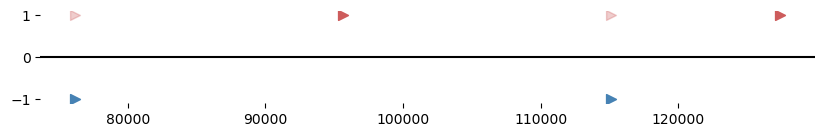

In [294]:
# right_border_counts = borders_df[borders_df.annotation.str.contains('right_border')].source_id.value_counts()
# left_border_counts = borders_df[borders_df.annotation.str.contains('left_border')].source_id.value_counts()
# right_border_counts = right_border_counts[right_border_counts > 3]
# right_border_counts
# left_border_counts

def filter_right_borders(target_df:pd.DataFrame):

    get_next = lambda i : 'none' if (i == (len(target_df) - 1)) else target_df.iloc[i + 1].annotation
    get_previous = lambda i : 'none' if (i == 0) else target_df.iloc[i - 1].annotation
    
    target_df = target_df.sort_values('start')
    target_df['previous_annotation'] = [get_previous(i) for i in range(len(target_df))]
    target_df['next_annotation'] = [get_next(i) for i in range(len(target_df))]

    mask = (target_df.annotation.str.contains('right_border'))
    mask = mask & target_df.next_annotation.str.contains('none|left_border')
    mask = mask & target_df.previous_annotation.str.contains('none|left_border')
    return target_df[mask].copy()

def plot_borders(target_df:pd.DataFrame):

    fig, ax = plt.subplots(figsize=(10, 1.2))
    target_length = target_df.length.iloc[0]

    palette = {'T-DNA_right_border':'indianred', 'T-DNA_left_border':'steelblue'}
    y = {'T-DNA_right_border':1, 'T-DNA_left_border':-1}

    target_df = target_df[target_df.annotation.isin(y)].copy()
    resolved_target_df = resolve_borders(target_df, filter_=False)

    ax.axhline(xmin=0, xmax=target_length, color='black')

    def plot(df, alpha=1):
        for annotation, df_ in df.groupby('annotation'):
            for row in df_.itertuples():
                dx = row.stop - row.start if (row.strand == '+') else -row.stop - row.start
                x = row.start if (row.strand == '+') else row.stop 
                marker = '>' if (row.strand == '+') else '<'
                ax.scatter([x], [y[annotation]],color=palette[annotation], s=50, marker=marker, alpha=alpha)

    plot(target_df, alpha=0.3)
    plot(resolved_target_df, alpha=1)
    # ax.set_visible(False)
    for _, spine in ax.spines.items():
        spine.set_visible(False)

hmmer_df = load_hmmer_files(hmmer_dir='../data/data-1/hmmer')
# plot_borders(hmmer_df[hmmer_df.target_name == 'JL5166_16'])
# plot_borders(hmmer_df[hmmer_df.target_name == 'AS1D6_11']) 
# plot_borders(hmmer_df[hmmer_df.target_name == 'NC_002575']) 
plot_borders(hmmer_df[hmmer_df.target_name == 'A4_12']) 

# For the purposes of detecting potential motifs, require that every valid right border have a corresponding left border

In [290]:
hmmer_df = load_hmmer_files(hmmer_dir='../data/data-1/hmmer')
overdrive_df = build_overdrive_dataset(overwrite=True, fasta_dir='../data/data-1/ncbi/fasta/', hmmer_df=hmmer_df, length=100, data_dir='../data/data-1/')

if 'plasmid_type' not in overdrive_df.columns:
    index = overdrive_df.index
    overdrive_df = overdrive_df.merge(metadata_df, left_on='source_id', right_on='source_id', how='left')
    overdrive_df.index = index # Make sure to restore the index after the merge. 

overdrive_df.to_csv('../data/data-1/overdrive.csv')
FASTAFile(df=overdrive_df).write('../data/data-1/overdrive.fn')

virc1_df = build_virc_dataset(overwrite=False, product='VirC1')
virc2_df = build_virc_dataset(overwrite=False, product='VirC2')

# Identified a handful of cases of detected overdrive variants which seem to multiple (4+) GTGCATCC repeats. I ran a BLASTn search, 
# and found other similar repeat regions in non-Agro bacteria, which suggests to me that this might be some kind of weird recombination
# event or replication slippage. I am going to exclude them from the dataset for now, as they are interfering with motif search. 

# is_weird_repeat = lambda seq : re.search(r'(GTGCATCC|GTGCCTTC|TGTTCAAT|AGTTCATT){3,}', seq) is not None 
# print(f'Removing {overdrive_df.seq.apply(is_weird_repeat).sum()} adjacent regions with repeats from the dataset.')
# overdrive_df = overdrive_df[~overdrive_df.seq.apply(is_weird_repeat)]

# right_border_false_positive_ids = ['JL5166_16:42807-43007', 'JL5166_18:12337-12537', 'JL5166_18:64464-64664', 'AS2E5_10:145466-145666']
# overdrive_df = overdrive_df[~overdrive_df.index.isin(right_border_false_positive_ids)]

overdrive_df.to_csv('../data/data-1/overdrive.csv')
FASTAFile(df=overdrive_df).write('../data/data-1/overdrive.fn')
FASTAFile(df=overdrive_df.drop_duplicates('left_of_right_border_seq').drop(columns=['seq']).rename(columns={'left_of_right_border_seq':'seq'})).write('../data/data-1/left_of_right_border.fn')


load_hmmer: Num. hits for query T-DNA_left_border: 296
load_hmmer: Num. hits for query T-DNA_right_border: 426
load_hmmer: Num. hits for query overdrive: 43
build_overdrive_dataset: Found 193 right borders.
build_overdrive_dataset: Found 142 FASTA files.


In [292]:
for seq in overdrive_df[overdrive_df.contig_id == 'A4_12'].seq:
    print(seq)

TGTTTGTTCAATTGTTCAATTGTTCAATTGTTCAATTGTTCAATTGTTAATGTATAAGTTCGTGATGAAGGATGGTTGTTTTAAAAATAGTATGTTTGAC
GGTAGATAAATTTGTGTGGAGGTATGTTTGTTTAGGACGGCGGTGATGATGGCTTGCGCCTTACGTCCCGAAAGCAGTCCACGAAGACAATTGCAATATC


In [221]:
# overdrive_df.left_of_right_border_seq.nunique()
# overdrive_df.seq.nunique()

# for row in overdrive_df.itertuples():
#     assert row.right_border_seq not in row.left_of_right_border_seq

# overdrive_df[[col for col in overdrive_df.columns if ('start' in col) or ('stop' in col)] + ['strand']]

check_overdrive_dataset: 100%|██████████| 183/183 [00:00<00:00, 2824.56it/s]


In [223]:
# There is tons of redundancy in the dataset... 

d = 0
virc2_df['beta_sheet_1'] = [seq[80 - d:90 + d] for seq in virc2_df.seq]
virc2_df['beta_sheet_2'] = [seq[150 - d:160 + d] for seq in virc2_df.seq]
virc2_df['beta_sheets'] = [row.beta_sheet_1 + '-' + row.beta_sheet_2 for row in virc2_df.itertuples()]

overdrive_variants = {seq:i for i, seq in enumerate(overdrive_df.seq.unique())}
overdrive_df['variant'] = overdrive_df.seq.map(overdrive_variants)

overdrive_df['virc1_seq'] = overdrive_df.source_id.map(virc1_df.set_index('source_id').seq)
overdrive_df['virc2_seq'] = overdrive_df.source_id.map(virc2_df.set_index('source_id').seq)
overdrive_df['virc2_beta_sheet_1'] = overdrive_df.source_id.map(virc2_df.set_index('source_id').beta_sheet_1)
overdrive_df['virc2_beta_sheet_2'] = overdrive_df.source_id.map(virc2_df.set_index('source_id').beta_sheet_2)
overdrive_df['virc2_beta_sheets'] = overdrive_df.source_id.map(virc2_df.set_index('source_id').beta_sheets)

# Only assign variant IDs to the VirC1 and VirC2 sequences with identified overdrives.
virc1_variants = {seq:i for i, seq in enumerate(overdrive_df.virc1_seq.unique())}
virc2_variants = {seq:i for i, seq in enumerate(overdrive_df.virc2_seq.unique())}
virc2_beta_sheet_1_variants = {seq:i for i, seq in enumerate(overdrive_df.virc2_beta_sheet_1.unique())}
virc2_beta_sheet_2_variants = {seq:i for i, seq in enumerate(overdrive_df.virc2_beta_sheet_2.unique())}
virc2_beta_sheets_variants = {seq:i for i, seq in enumerate(overdrive_df.virc2_beta_sheets.unique())}

overdrive_df['virc1_variant'] = overdrive_df.virc1_seq.map(virc1_variants)
overdrive_df['virc2_variant'] = overdrive_df.virc2_seq.map(virc2_variants)
overdrive_df['virc2_beta_sheets_variant'] = overdrive_df.virc2_beta_sheets.map(virc2_beta_sheets_variants)

virc1_df['variant'] = virc1_df.seq.map(virc1_variants)
virc2_df['variant'] = virc2_df.seq.map(virc2_variants)

print('Num. overdrive variants:', overdrive_df.seq.nunique())
print('Num. VirC1 variants:', overdrive_df.virc1_seq.nunique())
print('Num. VirC2 variants:', overdrive_df.virc2_seq.nunique())
print('Num. VirC2 variants (first beta sheet):', overdrive_df.virc2_beta_sheet_1.nunique())
print('Num. VirC2 variants (second beta sheet):', overdrive_df.virc2_beta_sheet_2.nunique())
print('Num. VirC2 variants (both beta sheets):', overdrive_df.virc2_beta_sheets.nunique())

overdrive_df.to_csv('../data/data-1/overdrive.csv')

Num. overdrive variants: 27
Num. VirC1 variants: 10
Num. VirC2 variants: 16
Num. VirC2 variants (first beta sheet): 5
Num. VirC2 variants (second beta sheet): 4
Num. VirC2 variants (both beta sheets): 5


In [224]:
palette = get_palette(overdrive_df.sort_values('plasmid_class'), field='plasmid_type')

In [225]:
# Are there any overdrive sequences which are missing corresponding VirC12 proteins?
print('Num. overdrive sequences without annotated VirC1:', overdrive_df.virc1_seq.isnull().sum())
for row in overdrive_df[overdrive_df.virc1_seq.isnull()].itertuples():
    print(row.source_id) # Looking at the GenBank files, it seems as though these plamids are just missing part of the vir operon. 

Num. overdrive sequences without annotated VirC1: 3
NCPPB_3554_ti
Y2_73_ti
Y2_73_ti


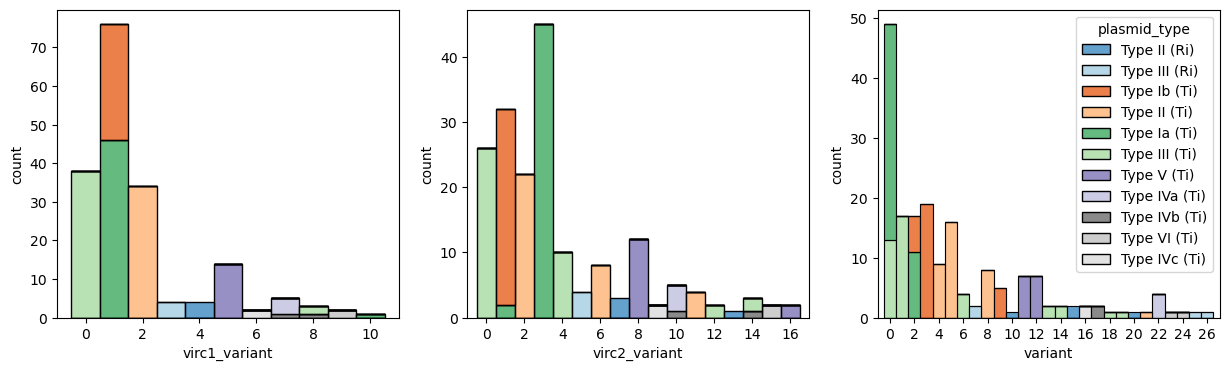

In [281]:
def figure(overdrive_df:pd.DataFrame, palette:dict=palette):

    figure_df = overdrive_df.copy()
    figure_df = figure_df.sort_values('plasmid_class')

    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

    variant_fields = ['virc1_variant', 'virc2_variant', 'variant']
    # variant_fields = ['virc1_variant', 'virc2_beta_sheets_variant', 'variant']
    for ax, variant_field in zip(axes, variant_fields):
        ax_df = figure_df.copy()
        ax_df = ax_df[~ax_df[variant_field].isnull()].copy()
        ax_df[variant_field] = ax_df[variant_field].astype(int)
        
        add_legend = (variant_field == variant_fields[-1])
        # add_legend = False
        sns.histplot(data=ax_df, ax=ax, x=variant_field, hue='plasmid_type', legend=add_legend, multiple='stack', palette=palette, discrete=True)
        # sns.histplot(data=figure_df, ax=ax, x='plasmid_type', hue='variant', legend=False, multiple='stack', palette='tab20c')
        ax.set_ylabel('count')
        # ax.set_ylim(ymax=20)
        ax.set_xticks(np.arange(0, figure_df[variant_field].nunique(), 2))
        # ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45)
        ax.set_xlim(xmin=-1, xmax=figure_df[variant_field].nunique())
    plt.show()

figure(overdrive_df)

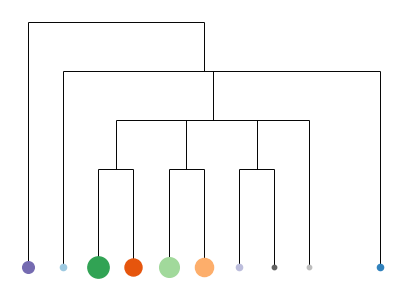

In [277]:
def figure(overdrive_df, palette=palette):

    fig, ax = plt.subplots(figsize=(5, 3.5))

    coords = dict()
    coords['Type V (Ti)'] = 0, (1, 0)
    coords['Type III (Ri)'] = 1, (2, 0)
    coords['Type Ia (Ti)'] = 3, (3, 0)
    coords['Type Ib (Ti)'] = 3, (4, 0)
    coords['Type III (Ti)'] = 3, (5, 0)
    coords['Type II (Ti)'] = 3, (6, 0)
    coords['Type IVa (Ti)'] = 3, (7, 0)
    coords['Type IVb (Ti)'] = 3, (8, 0)
    coords['Type VI (Ti)'] = 2, (9, 0)
    # coords['Type I (Ri)'] = (10, 0)
    coords['Type II (Ri)'] = 1, (11, 0)

    max_height = 5
    levels = [max_height, max_height - 1, max_height - 2, max_height - 3]
    
    ax.hlines(max_height, xmin=1, xmax=(11 + 1) / 2, color='black', lw=0.7)
    ax.hlines(max_height - 1, xmin=2, xmax=11, color='black', lw=0.7)
    ax.hlines(max_height - 2, xmin=(3 + 4) / 2, xmax=9, color='black', lw=0.7)
    ax.hlines(max_height - 3, xmin=3, xmax=4, color='black', lw=0.7)
    ax.hlines(max_height - 3, xmin=5, xmax=6, color='black', lw=0.7)
    ax.hlines(max_height - 3, xmin=7, xmax=8, color='black', lw=0.7)

    ax.vlines((11 + 1) / 2, ymin=levels[1], ymax=levels[0], color='black', lw=0.7)
    ax.vlines((((3 + 4) / 2) + 9) / 2, ymin=levels[2], ymax=levels[1], color='black', lw=0.7)
    ax.vlines((3 + 4) / 2, ymin=levels[3], ymax=levels[2], color='black', lw=0.7)
    ax.vlines((5 + 6) / 2, ymin=levels[3], ymax=levels[2], color='black', lw=0.7)
    ax.vlines((7 + 8) / 2, ymin=levels[3], ymax=levels[2], color='black', lw=0.7)

    sizes = overdrive_df.plasmid_type.value_counts().to_dict()

    for label, (level, (x, y)) in coords.items():
        ax.vlines(x, ymin=0, ymax=levels[level], color='black', zorder=-1, lw=0.7)
        ax.scatter([x], [y], color=palette[label], s=5 * sizes[label], label=label)

    for _, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.legend()

    plt.show()

figure(overdrive_df)




In [241]:
# How many unique VirC1-VirC2 combinations?

virc1_virc2_pairs = set([(row.virc1_variant, row.virc2_variant) for row in overdrive_df.itertuples()])

# If you know VirC1, how well can you predict overdrive?
# If you know VirC2, how well can you predict overdrive?
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score

df = overdrive_df[~(overdrive_df.virc1_seq.isnull() | overdrive_df.virc2_seq.isnull())].copy()
# print(adjusted_mutual_info_score(df.variant.values, df.virc1_variant.values))
# print(adjusted_mutual_info_score(df.variant.values, df.virc2_variant.values))
print(adjusted_mutual_info_score(df.reduced_variant.values, df.virc1_variant.values))
print(adjusted_mutual_info_score(df.reduced_variant.values, df.virc2_variant.values))

print(adjusted_mutual_info_score(df.virc1_variant.values, df.virc2_variant.values))


0.5837230383026172
0.5739563463993702
0.7932129532143046


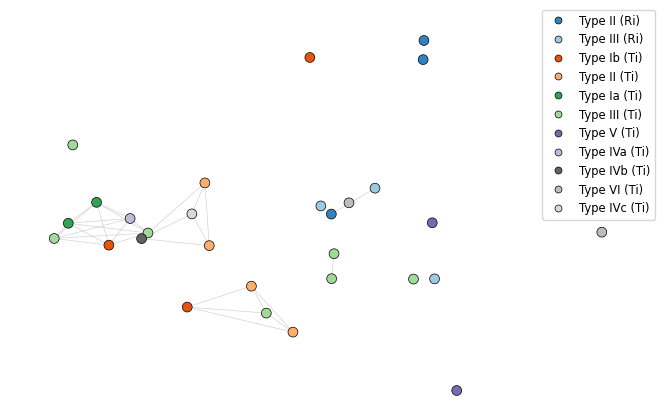

In [236]:
# We can see that identical upstream regions are generally limited to plasmids of the same type, with the exception
# of some which are found in both Type 1a and Type 1b plasmids, as well as Type 1a and Type III. 

# Would be useful to look at how exactly these regions compare. Because most of the overdrive variants correspond to a single
# plasmid type, it is probably OK to drop (variant, plasmid_type) duplicates. 

def figure(overdrive_df, palette=palette):

    get_id = lambda row : row.plasmid_type.split('(')[0].strip().lower().replace(' ', '_') + f'_var{row.variant}'

    figure_df = overdrive_df.copy()
    figure_df = figure_df.sort_values('plasmid_class')
    figure_df = figure_df.drop_duplicates(['variant', 'plasmid_type'])
    figure_df['id'] = [get_id(row) for row in figure_df.itertuples()]
    FASTAFile(df=figure_df.set_index('id')).write('../data/data-1/figure_2.fn')
    figure_df = figure_df.set_index('id')

    align_df = load_align('../data/data-1/figure_2_align.tsv')
    # Want to characterize the cross-variant alignments. 
    
    graph = get_alignment_graph(align_df, order=figure_df.index.values)
    alignment_groups = nx.connected_components(graph)
    alignment_groups = {i:set([int(re.search(r'\d+', id_).group(0)) for id_ in group]) for i, group in enumerate(alignment_groups)}

    fig, ax = plt.subplots(figsize=(8, 5))

    pos = get_layout(graph)

    colors = get_graph_colors(graph, figure_df, field='plasmid_type', palette=palette)
    nx.draw_networkx_edges(graph, ax=ax, pos=pos, edge_color='lightgray', width=0.5)
    nx.draw_networkx_nodes(graph, ax=ax, node_size=50, pos=pos, edgecolors='black', node_color=colors, linewidths=0.5)

    legend_labels = figure_df.plasmid_type.unique()
    legend_handles = [mpl.lines.Line2D([None], [None], ls='none', markersize=5, marker='o', markeredgewidth=0.5, markeredgecolor='black', markerfacecolor=palette.get(label)) for label in legend_labels]
    ax.legend(legend_handles, legend_labels, fontsize='small', bbox_to_anchor=(1.05, 1.05))

    for _, spine in ax.spines.items():
        spine.set_visible(False)

    plt.show()

    return align_df, alignment_groups

align_df, alignment_groups = figure(overdrive_df)

In [ ]:
reduced_variants = {variant:i for i, group in alignment_groups.items() for variant in group}
overdrive_df['reduced_variant'] = overdrive_df.variant.map(reduced_variants)

In [284]:
# Strains C58, Ach5, Bo542, A4

# The DNA-binding regions for all three strains are nearly identical. 
df = overdrive_df[overdrive_df.strain_id.isin(['C58', 'Bo542', 'Ach5', 'A4'])].copy()

# Bo542 and Ach5 have VirC2s with identical DNA binding domains. 
# A4 and C58 have VirC2s with identical DNA binding domains. 

# Ach5 and A4 have identical motifs, despite having VirC2s with different binding domains. 
df[['strain_id', 'virc1_variant', 'virc2_variant', 'virc2_beta_sheets', 'plasmid_type', 'variant', 'reduced_variant']]#.drop_duplicates('strain_id')

,strain_id,virc1_variant,virc2_variant,virc2_beta_sheets,plasmid_type,variant,reduced_variant
id,,,,,,,
A4_12:127426-127526,A4,3,5,KIQVFLSARP-IVQTSRMFPV,Type III (Ri),7,1
NZ_CP011249:13177-13277,Ach5,2,2,KLQVFLSARP-VQTSRMFPVA,Type II (Ti),8,6
NZ_CP011249:22880-22980,Ach5,2,2,KLQVFLSARP-VQTSRMFPVA,Type II (Ti),5,10
DQ058764:15729-15829,Bo542,0,0,KLQVFLSARP-VQTSRMFPVA,Type III (Ti),13,9
DQ058764:42315-42415,Bo542,0,0,KLQVFLSARP-VQTSRMFPVA,Type III (Ti),14,10
AE007871:24834-24934,C58,1,1,KIQVFLSARP-IVQTSRMFPV,Type Ia (Ti),2,7
